In [1]:
import numpy as np
import pandas as pd
import json
import csv
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 # Loading Data

In [3]:
# Reading gni88.json to a Pandas df
arts = pd.read_json("/content/drive/MyDrive/data/gni88.json", lines=True)

In [4]:
# importing data for which speaker names have already been cleaned
qtes_just_names = pd.read_csv("/content/drive/MyDrive/data/qtes_just_names.csv")

In [3]:
# importing cleaned full dataset from local storage
cleaned_data = pd.read_csv("../../Data/cleaned_data/GNI88_cleaned_data.csv")
cleaned_data

/tmp/ipykernel_1017/822843550.py:2: DtypeWarning: Columns (9,10,24) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv("../../Data/cleaned_data/GNI88_cleaned_data.csv")


,artdate,Article ID,Headline,Quote ID,Article Status,Article Position,Messages,Submessages,Quote Position,Legacy Quote Tag,...,Constituent Group,Media Name,Media Medium,Journalist Name,Constituent Author,Article Issues,Custom Group,Media Group,fulltext,source_name_cleaned
0,2018-02-05,3774467,Opinion: They Voted for Caps. Now They Want Mo...,7096188,Opinion,Neutral,OLD Spending,OLD Nukes Budget Campaign,Neutral,NaN,...,None (Legacy Other),Roll Call,Print,"Bell, Steve",NaN,NaN,Commentary,Capitol Hill Media,Opinion: They Voted for Caps. Now They Want Mo...,Steve Bell
1,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105520,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,None (Legacy Other),News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,James Mattis
2,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105517,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,None (Legacy Other),News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,James Mattis
3,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105518,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Positive,NaN,...,NaN,News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,Leon E. Panetta
4,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105527,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,NaN,News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,Chuck Hagel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408199,2018-02-15,3777408,"No 'bloody nose' strategy for North Korea, say...",7105511,News,Positive,OLD Proliferation,OLD State Level Nuclear Programs,Positive,NaN,...,None (Legacy Other),Defense News,NaN,"Gould, Joe",NaN,NaN,NaN,NaN,"No 'bloody nose' strategy for North Korea, say...",Unnamed Trump White House Official
408200,2018-02-15,3777408,"No 'bloody nose' strategy for North Korea, say...",7105519,News,Positive,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,None (Legacy Other),Defense News,NaN,"Gould, Joe",NaN,NaN,NaN,NaN,"No 'bloody nose' strategy for North Korea, say...",Susan Thornton
408201,2018-02-15,3777408,"No 'bloody nose' strategy for North Korea, say...",7105510,News,Positive,OLD Proliferation,OLD State Level Nuclear Programs,Positive,NaN,...,None (Legacy Other),Defense News,NaN,"Gould, Joe",NaN,NaN,NaN,NaN,"No 'bloody nose' strategy for North Korea, say...",Unnamed Source
408202,2018-02-15,3777409,Modernized Tu-160 to boost Russia's long-range...,7105550,News,Neutral,OLD Missile Defense,OLD European/Russian Missile Defense,Negative,NaN,...,None (Legacy Other),Defense News,NaN,"Bodner, Matthew",NaN,NaN,NaN,NaN,Modernized Tu-160 to boost Russia's long-range...,Vladimir Putin


# Filtering by Source Name
Some source names are annotated as "unnamed", or are not exact matches with the actual name in the article text, so this section is for counting or filtering those names.

In [4]:
# printing column names for reference
cleaned_data.columns

Index(['artdate', 'Article ID', 'Headline', 'Quote ID', 'Article Status',
       'Article Position', 'Messages', 'Submessages', 'Quote Position',
       'Legacy Quote Tag', 'On/Off Message', 'QText', 'Source Name',
       'Source Type', 'Source Party Affiliation', 'Source Ethnicity',
       'Source Nationality', 'Source Gender', 'Source Religion',
       'Legacy Source Tag', 'Constituent Group', 'Media Name', 'Media Medium',
       'Journalist Name', 'Constituent Author', 'Article Issues',
       'Custom Group', 'Media Group', 'fulltext', 'source_name_cleaned'],
      dtype='object')

In [5]:
# printing the value counts for the lowest-occurring 1000 names
cleaned_data["Source Name"].value_counts().tail(1000)

Abbas rezaei         1
Anmol Narang         1
Sina Golmakani       1
Lee Sukjoon          1
Vladimir Voronkov    1
                    ..
Aleksey Pushkov      1
Hesham Ghanbari      1
Ihor Romanenko       1
Mikhail Margelov     1
Steve Bell           1
Name: Source Name, Length: 1000, dtype: int64

In [6]:
cleaned_data["fulltext"]

0         Opinion: They Voted for Caps. Now They Want Mo...
1         Can James Mattis Prevent Nuclear War With Nort...
2         Can James Mattis Prevent Nuclear War With Nort...
3         Can James Mattis Prevent Nuclear War With Nort...
4         Can James Mattis Prevent Nuclear War With Nort...
                                ...                        
408199    No 'bloody nose' strategy for North Korea, say...
408200    No 'bloody nose' strategy for North Korea, say...
408201    No 'bloody nose' strategy for North Korea, say...
408202    Modernized Tu-160 to boost Russia's long-range...
408203    Putin Is Playing a Dangerous Game in Syria\r\n...
Name: fulltext, Length: 408204, dtype: object

In [7]:
# dropping rows with missing source names and article text
# there are about 8,000 rows dropped from this
cleaned_data = cleaned_data.dropna(subset=["Source Name", "fulltext"])
cleaned_data

,artdate,Article ID,Headline,Quote ID,Article Status,Article Position,Messages,Submessages,Quote Position,Legacy Quote Tag,...,Constituent Group,Media Name,Media Medium,Journalist Name,Constituent Author,Article Issues,Custom Group,Media Group,fulltext,source_name_cleaned
0,2018-02-05,3774467,Opinion: They Voted for Caps. Now They Want Mo...,7096188,Opinion,Neutral,OLD Spending,OLD Nukes Budget Campaign,Neutral,NaN,...,None (Legacy Other),Roll Call,Print,"Bell, Steve",NaN,NaN,Commentary,Capitol Hill Media,Opinion: They Voted for Caps. Now They Want Mo...,Steve Bell
1,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105520,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,None (Legacy Other),News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,James Mattis
2,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105517,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,None (Legacy Other),News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,James Mattis
3,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105518,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Positive,NaN,...,NaN,News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,Leon E. Panetta
4,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105527,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,NaN,News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,Chuck Hagel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408199,2018-02-15,3777408,"No 'bloody nose' strategy for North Korea, say...",7105511,News,Positive,OLD Proliferation,OLD State Level Nuclear Programs,Positive,NaN,...,None (Legacy Other),Defense News,NaN,"Gould, Joe",NaN,NaN,NaN,NaN,"No 'bloody nose' strategy for North Korea, say...",Unnamed Trump White House Official
408200,2018-02-15,3777408,"No 'bloody nose' strategy for North Korea, say...",7105519,News,Positive,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,None (Legacy Other),Defense News,NaN,"Gould, Joe",NaN,NaN,NaN,NaN,"No 'bloody nose' strategy for North Korea, say...",Susan Thornton
408201,2018-02-15,3777408,"No 'bloody nose' strategy for North Korea, say...",7105510,News,Positive,OLD Proliferation,OLD State Level Nuclear Programs,Positive,NaN,...,None (Legacy Other),Defense News,NaN,"Gould, Joe",NaN,NaN,NaN,NaN,"No 'bloody nose' strategy for North Korea, say...",Unnamed Source
408202,2018-02-15,3777409,Modernized Tu-160 to boost Russia's long-range...,7105550,News,Neutral,OLD Missile Defense,OLD European/Russian Missile Defense,Negative,NaN,...,None (Legacy Other),Defense News,NaN,"Bodner, Matthew",NaN,NaN,NaN,NaN,Modernized Tu-160 to boost Russia's long-range...,Vladimir Putin


In [8]:
# adding a column to denote presence of "unnamed" in source name
cleaned_data["Unnamed Source"] = cleaned_data["Source Name"].str.lower().str.contains("unnamed")
print(cleaned_data["Unnamed Source"].value_counts())

# dropping unnamed sources
cleaned_data = cleaned_data.loc[~cleaned_data["Unnamed Source"]]

False    356992
True      43452
Name: Unnamed Source, dtype: int64


/tmp/ipykernel_1017/3619176105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data["Unnamed Source"] = cleaned_data["Source Name"].str.lower().str.contains("unnamed")


In [9]:
# adding a column to denote exact matches of Source Name in fulltext
cleaned_data["Name in Text"] = cleaned_data.apply(lambda df: df["Source Name"] in df["fulltext"], axis=1)
cleaned_data["Name in Text"].value_counts()

/tmp/ipykernel_1017/1260051694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data["Name in Text"] = cleaned_data.apply(lambda df: df["Source Name"] in df["fulltext"], axis=1)


True     187808
False    169184
Name: Name in Text, dtype: int64

In [10]:
# adding a column to denote exact matches of cleaned Source Name in fulltext
cleaned_data["Name in Text"] = cleaned_data.apply(lambda df: df["source_name_cleaned"] in df["fulltext"], axis=1)
cleaned_data["Name in Text"].value_counts()

/tmp/ipykernel_1017/3874452738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data["Name in Text"] = cleaned_data.apply(lambda df: df["source_name_cleaned"] in df["fulltext"], axis=1)


True     225961
False    131031
Name: Name in Text, dtype: int64

# Establishing Speaker Categories

In [5]:
# dictionary containing the classification groups for all speaker types
source_groups = {"Foreign Government": ['Foreign Gov/Mil Official'],
                "Experts": ['Nuke Organization','Non-Profit/NGO','Think Tanks',
                            'Nuke Organization - Other', 'Nuke Organization - Academic',
                            'International Orgs','Academic','Nuclear Scientist',"Analyst/Commentator",
                            'Attorney','Regulator'],
                "US Congress": ['US Rep. & Staff','US Senate & Staff', 'Partisans/Fmr. Politicians'],
                "US Federal Officials": ['Federal Official','State/Local Official',
                                        'Former Admin. Officials','Judicial Official'],
                "US Defense": ['US Military','Defense Forces','Defense'],
                "Media": ["Media/Journalist","Blogger"],
                "Corporate Official": ['Corporate Official'],
                "Other": ['Other','Chairman','Terrorist/Extremist','Information minister',
                          'Religious/Clerical', 'Ambassador', 'Nuclear Official',
                          'Citizen','Public Polling','US Police','Deputy']}

In [111]:
# Helper function that inverts a dictionary. This will be useful for using speaker groups
# later on in model evaluation
def invert_dict(dictionary):
  """Inputs:
     - dictionary: dict, dictionary we wish to invert
     Outputs:
     - dict, where keys are the initial dictionary's values and values are the initial dictionary's keys"""
  # get a list of all items in all dictionary values
  speaker_types = list(np.concatenate(list(dictionary.values())).flat)
  # each speaker type will become its own key now, and the value will be the speaker group it's a part of
  inverted_dict = {}
  for speaker_type in speaker_types:
    # find the group the speaker_type belongs in
    speaker_group = [key for key, value in dictionary.items() if speaker_type in value][0]
    # update the inverted dictionary such that the key is the speaker type and the value is the speaker group
    inverted_dict[speaker_type] = speaker_group
  return inverted_dict

In [114]:
# lookup dictionary which can convert a speaker type to its classification group in constant time
source_to_group = invert_dict(source_groups)

In [115]:
def assign_source_to_group(source_type):
  """Inputs:
     - source_type: str, source type from quote datafame
     Outputs:
     - str of the bigger speaker category to which source_type belongs"""
  if type(source_type) != str:
    return "Other"
  else:
    return source_to_group[source_type]

# Establishing Classification Features

In [77]:
# Listing indicidator features to compare across the speaker categories
experts_ps = ["associate professor",
              "university",
              "studies",
              "scholar",
              "expert",
              "historian",
              "academy",
              "social science",
              "lecturer",
              "physicist",
              "professor",
              "political science",
              "political",
              "scientist",
              "college",
              "education",
              "school",
              "economics",
              "international relations",
              "physics",
              "associate professor",
              "researcher",
              "laboratory",
              "research fellow",
              "graduate school",
              "international affairs",
              "research associate",
              "dr\.",
              "ph\.d\.",
              "institute of technology",
              "economist",
              "analysis",
              "counselor",
              "postdoctoral",
              "fellow",
              "specialist",
              "novelist",
              "founder",
              "council",
              "director",
              "program",
              "think tank",
              "foundation",
              "institute",
              "division",
              "policy",
              "association",
              "center",
              "group",
              "superindendent",
              "international"]
foreign_gov_ps = ["putin|kim jong un|netanyahu|ayatollah|moon jae in",
                  "[nseih] president",
                  "[nseih] foreign",
                  "foreign minister",
                  "foreign ministry",
                  "prime minister",
                  "people's liberation army",
                  "foreign policy",
                  "supreme leader",
                  "prince"] 
corporate_official_ps = ["chief finnancial officer",
                         "managing director",
                         "bank",
                         "chief executive",
                         "general manager",
                         "investment fund",
                         "investment",
                         "employer",
                         "firm",
                         "chief executive officer",
                         "businessman",
                         "businesswoman",
                         "inc\.",
                         "manager",
                         "ltd[ ,\.]",
                         "chairman",
                         "chairwoman",
                         "sales",
                         "managing",
                         "program director",
                         "strategist",
                         "company",
                         "contractor",
                         "consultancy"]
judicial_ps = ["attorney",
               "justice",
               "lawyer",
               "court",
               "judge",
               "magistrate"]
us_congress_ps = [" sen\.",
                  " rep\.",
                  " sens\.",
                  " reps\.",
                  " r ",
                  " d ",
                  "\(r",
                  "\(d",
                  "democrat",
                  "democratic",
                  "republican",
                  "majority leader",
                  "minority leader",
                  "senate",
                  "house",
                  "committee",
                  "frontrunner",
                  "candidate",
                  "committee chairman",
                  "ranking member",
                  " top",
                  "foreign relations committee",
                  "intelligence committee",
                  "hopeful",
                  "house speaker",
                  "campaign"]
us_defense_ps = ["pentagon",
                 "navy",
                 "air force",
                 "army",
                 "marine",
                 "coast gaurd",
                 " capt\.",
                 "captain",
                 " gen\.",
                 "general",
                 " adm\.",
                 "admiral",
                 " col\.",
                 "colonel",
                 " lt\.",
                 "lieutenant",
                 "chief of staff",
                 "joint chiefs of staff",
                 "commander",
                 "norad",
                 "northcom",
                 "special forces",
                 "strategic command",
                 "defense secretary",
                 "nato",
                 "allied",
                 "officer",
                 "corps",
                 " u\.s\.",
                 " us "]
us_fed_officials_ps = ["biden|trump|obama|bush|clinton|reagan",
                        "ambassador",
                        "u\.s\. president",
                        "department",
                        "attorney",
                        "secretary of",
                        "us ambassador",
                        "state department",
                        "national security",
                        "secretary",
                        "secretary of"]
media_ps = ["author\:? ",
            "correspondent",
            "columnist",
            " post",
            " host",
            "editor",
            "times",
            "press",
            "magazine",
            "msnbc|cnn|fox",
            "writer",
            "syndicated columnist",
            "editorial",
            "blog",
            ": .+",
            "i\"m",
            "by\:? ",
            "media_tag"] 
international_officials_ps = ["deputy director general",
                              "international atomic energy agency",
                              "iaea",
                              "inspector",
                              "inspections"]
other_ps = ["hezbollah",
            "taliban",
            "pollster",
            "archbishop",
            "pope",
            "bishop",
            "church",
            "rev\.",
            "reverand",
            "police",
            "commissioner",
            "nypd",
            "resident"]

In [ ]:
indicator_pattern_set  = [experts_ps,
                          foreign_gov_ps,
                          corporate_official_ps,
                          judicial_ps,
                          us_congress_ps,
                          us_defense_ps,
                          us_fed_officials_ps,
                          media_ps,
                          international_officials_ps,
                          other_ps]

In [80]:
indicator_patterns = []
for pattern_group in indicator_pattern_set:
  indicator_patterns += pattern_group

In [83]:
# A special indicator to try is the existence of a foreign title--that is, any case in which
# a title and a foreign cuntry are mentioned in the same string. Examples are shown below.
def has_foreign_title(context_str):
  """Inputs:
     - context_str: string to find a foreign title in
     Outputs:
     - int, whether or not a foreign title is in the string"""
  country_pattern = "iran|iraq|south korea|north korea|russia|china|france|germany|india|pakistan|libya|britain|u\.k\.|united kingdom|israel|saudi arabia"
  country_s_pattern = "(iran|iraq|south korea|north korea|russia|china|france|germany|india|pakistan|libya|britain|u\.k\.|united kingdom|israel|saudi arabia|south|north|korea).?s"
  country_adj_pattern = "iranian|iraqi|south korean|north koren|russian|chinese|french|german|indian|pakistani|libyan|british|israeli|saudi"
  title_pattern = "foreign|defense|minister|ambassador|leader|president|prince|diplomat|prime minister|spokesman|spokeswoman|gen\.|governor|chief|government"
  country_match = re.search(country_pattern, context_str)
  s_match = re.search(country_s_pattern, context_str)
  adj_match = re.search(country_adj_pattern, context_str)
  title_match = re.search(title_pattern, context_str)
  has_country = False 
  has_title = False
  if s_match or adj_match or country_match:
    has_country = True
  if title_match:
    has_title = True
  return int(has_country and has_title)

# Context Extraction Setup

In [84]:
# NLTK will be useful for parsing context sentences. We rely on an understanding of
# what words are nouns in order to extract certain context patterns

# Instructions: Downloader will prompt a response. Respond as follows:
# - d   (and enter)
# - all (and enter)
# - q   (and enter)
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> 

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /root/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Package averaged_perceptron_tagger is already up-to-date!
       | Downloading package averaged_perceptron_tagger_ru to
       |

True

In [85]:
# More NLTK setup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
stop_words = set(stopwords.words('english'))

In [86]:
# helper function to extract full article text, useful for debugging cases where the context extraction function fails
def content_of(art_id):
  """Inputs:
     - art_id: id of the article to get the full text of
     Outputs:
     - str: the full article content as a string"""
  just_id = arts[arts["Article ID"] == art_id]["Content"]
  if len(just_id) > 0:
    return arts[arts["Article ID"] == art_id]["Content"].iloc[0]
  else: 
    return ""

In [87]:
# Helper function to find the context for a speaker if the context follows a prenoun pattern
# Example: "Russian president Vladimir Putin" -- useful context nouns "Russian president" precede Putin's name
def find_prenoun_pattern(name, mentions):
  """Inputs:
     - name: str, name of the speaker we're looking for context for
     - mentions: list of str, all paragraphs in the article where name has appeared
     Outputs:
     - str: the prenoun context preceding a name's mention, if it exists. If no prenoun
            context is found, return an empty string."""
  # listing pos tags we can reference
  nouns = ['NN','NNS','NNP','NNPS']
  verbs = ['VB','VBD','VBG','VBN','VBP','VBZ']
  adverbs = ['RB','RBR','RBS']
  # get last name and name length (num words in name) for reference
  last_name = name.split()[-1]
  name_len = len(name.split())
  # for each sentence in the article that name appears in:
  for mention in mentions:
    potential_verb = ""
    # tokenize the sentence and parse it to see what part of speech (pos)
    # every word in it is
    wordsList = nltk.word_tokenize(mention) # note: we're keeping stopwords
    tagged = nltk.pos_tag(wordsList)
    if len(tagged) <= 1:
      return ""
    # now we iterate through the sentence
    sentence_legend = {}
    name_idx = 0
    i = 0
    # for each word in sentence:
    for tag_pair in tagged:
      sentence_legend[i] = tag_pair
      # if we find the last name, save that word index. It'll be handy
      if tag_pair[0] == last_name:
        name_idx = i
      i += 1
      
    # using the word index of the name, go back in the sentence to find the
    # word preceding it. If that preceding word is a noun, we have a prenoun
    # pattern we should extract! (we know it's a noun because of NLTK functionality)
    if name_idx - name_len >= 0:
      preceding_word_pos = sentence_legend[name_idx-name_len][1] 
      if preceding_word_pos in nouns:
        prenoun_pattern = ".*?((?:\w+\W+){1,4})" + name
        matches = re.search(prenoun_pattern, mention)
        if matches:
          #print(mention)
          return matches[1]
  return ""

In [88]:
# hardcoded list of names that are so recognizable that they often lack context.
# we will search for them manually so as not to confuse the algorithm with noisy context
household_names = ['donald trump','barack obama','ayatollah ali khameni',
                   'vladimir putin','kim jong un', 'joe biden', 'joseph biden', 
                   'george bush', 'benjamin netanyahu', "mitt romney"]

In [89]:
# Beefed up context extraction function that searches for many more possible context patterns
def fancy_context(art_id, name, verbose=False):
  """Inputs:
     - art_id: int, id of the article in which name spoke a quote
     - name: str, name of the speaker to search for context for
     - verbose: bool, whether or not to print a log of what patterns
                were found
     Outputs:
     - str: relevant context that can help identify name in article art_id.
            if no patterns could be matched, this string will be NO CONTEXT FOUND.
            if name is a household name, return the name alone. We have an indicator
            to handle it later."""
  content = content_of(art_id)
  # standardize article content and name to make searching easier
  content = content.lower()
  content = content.replace("-"," ")
  content = re.sub(' \w\. ',' ',content) # remove middle initials
  content = content.replace("'","")
  name = name.lower()
  name = name.replace("-", " ")
  name = name.replace("'", "")
  # initial hardcoded check for household names, since these names often don't
  # have any context and will only confuse the algorithm
  if name in household_names:
    return name
  last_name = name.split()[-1]

  # split the full text into a list of paragraphs
  paragraphs =  re.split(r"\n", content)
  # find paragraphs where the name is mentioned
  mentions = []
  for paragraph in paragraphs:
    if name in paragraph:
      mentions.append(paragraph)
  
  # BEGIN PATTERN MATCHING
  #writer_pattern1 = '(author\:? |by\:? )' + name
  writer_pattern1 = '(author\:? )' + name
  #writer_pattern2 = '(\n' + name + '.{0,10}\n)'
  writer_pattern2 = name+'   \r'
  congress_pattern = '(\w{3}. ' + name + ' \([dr]{1} .+\))'
  precontext_pattern = '([,\.!?].+, )' + name
  is_pattern = name + ' (is .+[,\.!?])'
  postcontext_pattern = name + '(,.+[,\.!?])'
  catchall_pattern = '(\W+(?:\w+\W+){0,6}' + name + '\W+(?:\w+\W+){0,12})'
  context = ""

  # try writer pattern (E: 'By: Johnny Harris')
  for mention in mentions:
    matches = re.search(writer_pattern1, mention)
    if matches:
      context = matches[1]
      break
    matches = re.search(writer_pattern2, mention)
    if matches:
      context = "media_tag"
      break
  if context:
    if verbose:
      print("WRITER PATTERN")
    return context

  # try congress pattern (E: 'sen. John McCain (r ariz.))
  for mention in mentions:
    matches = re.search(congress_pattern, mention)
    if matches:
      context += matches[1]
  if context:
    if verbose:
      print("CONGRESS PATTERN")
    return context

  # try prenoun pattern (E: 'Press secretary Jen Psaki')
  prenoun_result = find_prenoun_pattern(name, mentions)
  if prenoun_result:
    if verbose:
      print("PRENOUN PATTERN")
    return prenoun_result

  # try precontext patterns (E: 'Director of international affairs, Rob Black')
  for mention in mentions:
    matches = re.search(precontext_pattern, mention)
    if matches:
      context += matches[1]
  if context:
    if verbose:
      print("PRECONTEXT PATTERN")
    return context

  # try is pattern (E: 'Ezra Klein is a writer for the New York Times')
  for mention in mentions:
    matches = re.search(is_pattern, mention)
    if matches:
      context += matches[1]
  if context:
    if verbose:
      print("IS PATTERN")
    return context

  # try postcontext pattern (E: 'Daniel Chung, a researcher for ReThink media, ...')
  for mention in mentions:
      matches = re.search(postcontext_pattern, mention)
      if matches:
        context += matches[1]
  if context:
    if verbose:
      print("POSTCONTEXT PATTERN")
    return context

  # if all else fails, extract the first few words both preceding and trailing mentions
  # of name in the article. A less surgical extraction, but still an extraction.
  for mention in mentions:
      matches = re.search(catchall_pattern, mention)
      if matches:
        context += matches[1]
        break
  if context:
    if verbose:
      print("CATCHALL FOR " + str(art_id) + ", " + name)
    return context

  # if all else REALLY fails, run the whole function again with just the speaker's
  # last name, since sometimes they are mentioned as "Mr. last_name" or "Mrs. last_name"
  if len(name.split()) > 1:
    return fancy_context(art_id, last_name)
  else:
    context = "# NO CONTEXT FOUND #"
    if verbose:
      print("NO PATTERN FOUND FOR " + str(art_id) + ", " + name)
    return context

In [90]:
def extract_indicators(context_str, indicator_patterns):
  """Inputs:
     - context_str: str, the article content to extract indicator features from
     - indicator_patterns: list, all the patterns to be turned into indicators
     Outputs:
     - array of indicators in the order of indicator_patterns, where a 1 indicates
       that the corresponding pattern from indicator_patterns is present in 
       context_str"""

  # initialize a vector of length len(indicator_patterns)
  feat_vector = np.zeros(len(indicator_patterns))
  # for each pattern in indicator_patterns:
  i = 0
  for pattern in indicator_patterns:
    # search for the pattern in context_str
    match = re.findall(pattern, context_str)
    # if it's there, make that entry in the vector a 1
    # otherwise, leave it a 0
    if match:
      feat_vector[i] = 1
    i += 1
  # return the vector, that's our feature data
  return feat_vector

# Obtaining Training and Testing Data

In [116]:
# pulling a subset of current quote data to test a classifier on
sample_qte_data = qtes_just_names.sample(10000, random_state=22)

# Creating a Design Matrix from Extracted Context Data

In [117]:
# creating a column for feature information 
sample_qte_data["speaker_context"] = sample_qte_data.apply(lambda row: fancy_context(row["Article ID"], row["cleaned_name"],verbose=False),axis=1) 

In [118]:
# creating a column for label information
sample_qte_data["speaker_group"] = sample_qte_data.apply(lambda row: assign_source_to_group(row["Source Type"]),axis=1)

In [119]:
# creating a special indicator column to hopefully discern foreign government sources
sample_qte_data["has_foreign_title"] = sample_qte_data.apply(lambda row: has_foreign_title(row.speaker_context), axis = 1)

In [95]:
# X is the matrix of indicators based on quote context
X = []
X_verbose = []
for context_str in sample_qte_data["speaker_context"]:
  X_verbose.append(context_str)
  X.append(extract_indicators(context_str,indicator_patterns))
  #X.append(extract_counts(context_str,indicator_pattern_set))
X = np.array(X)
foreign_title_indicators = np.array([np.array([ind]) for ind in sample_qte_data["has_foreign_title"]])
X = np.hstack((X,foreign_title_indicators))

# Y is the broader group of speakers to which the source of the quote belongs
y = np.array(sample_qte_data["speaker_group"])

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
# train-test split for trial logistic classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

## Try: Logistic regression

In [98]:
from sklearn.linear_model import LogisticRegression

In [99]:
# fitting the trial logistic classifier
log_clf = LogisticRegression(max_iter=3000).fit(X_train, y_train)

In [100]:
# score for trial logistic classifier
log_clf.score(X_test,y_test)

0.6756666666666666

## Try: Random Forest

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [125]:
# fitting the trial random forest classifier
randforest_clf = RandomForestClassifier(max_depth=90, random_state=0, n_estimators=300).fit(X_train, y_train)

In [126]:
# score for trial random forest classifier
randforest_clf.score(X_test,y_test)

0.6736666666666666

In [122]:
# helper function that returns the random forest predicted category for a given context string
# useful for error analysis!
def forest_classify(context_str):
  indicator_vector = np.concatenate((extract_indicators(context_str, indicator_patterns), np.array([has_foreign_title(context_str)])),axis=None)
  return randforest_clf.predict([indicator_vector])

forest_classify = np.vectorize(forest_classify)

## Try: Support Vector Machine

In [105]:
from sklearn import svm
from sklearn import metrics

In [106]:
# fitting the trial SVM classifier
svm_clf = svm.SVC(kernel='linear').fit(X_train, y_train)

In [123]:
# score for trial SVM classifier
y_pred = svm_clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6673333333333333


# Hyperparameter Tuning

## Method 1: Quick-and-Dirty EDA

Less robust but way faster, also shows that exact hyperparam values aren't as important as knowing the right range they should be in.

In [109]:
# Plotting accuracy for combinations of n (num_estimators) and md (max_depth) parameters
accuracies = []
for md in np.arange(10, 100, 10):
  md_accuracies = []
  for n in np.arange(10, 200, 10):
    randforest_clf = RandomForestClassifier(max_depth=md, random_state=0, n_estimators=n).fit(X_train, y_train)
    md_accuracies.append(randforest_clf.score(X_test,y_test))
  accuracies.append(md_accuracies)

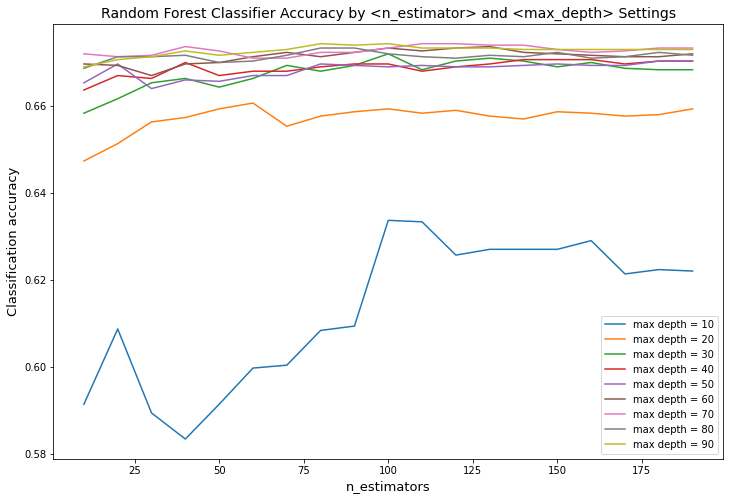

In [124]:
# Plotting hyperparameter tuning results
plt.figure(figsize=[12,8]);
i = 1
for subaccuracies in accuracies:
  plt.plot(np.arange(10, 200, 10), subaccuracies, label="max depth = " + str(i*10));
  i += 1
plt.title("Random Forest Classifier Accuracy by <n_estimator> and <max_depth> Settings", fontsize=14)
plt.xlabel("n_estimators",fontsize=13);
plt.ylabel("Classification accuracy",fontsize=13);
plt.legend();

## Method 2: Randomized GridSearch

More robust but has a prohibitively long runtime. The functions are detailed below for reference, but our team did not use gridsearch hyperparameters in our final model.

In [127]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# change labels to binary or else model errors
y_train_binary = pd.get_dummies(y_train)
y_test_binary = pd.get_dummies(y_test)

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 25)], # amt of trees in random forest
               'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)], # Maximum number of levels in tree
               'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
               'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
               'bootstrap': [True, False]} # Method of selecting samples for training each tree

def findBestRandomParameters(random_grid, n, X_train, y_train, X_test, y_test):
    """Randomly searches across n different combinations from random_grid and returns the best parameters
    and its associated score on the test dataset."""
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                                   n_iter = n, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    return rf_random.best_params_, rf_random.score(X_test,y_test)

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

def findBestGridParamters(param_grid):
    """Evaluates all combinations and returns the best parameters and its associated score on the test dataset."""
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.score(X_test,y_test)

In [128]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}

def findBestSVMParameters(param_grid, X_train, y_train):
    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
    grid.fit(X_train, y_train)
    grid_predictions = grid.predict(X_test)
    return grid.best_params_, grid_predictions

#print(classification_report(y_test, grid_predictions))

# Error Analysis

In [129]:
# creating a dataframe to compare out model's predictions to reality
probs_vs_actual = pd.DataFrame(randforest_clf.predict_proba(X_test),columns=source_groups)
probs_vs_actual["Actual"] = np.array(y_test)
probs_vs_actual["Prediction"] = np.array(randforest_clf.predict(X_test))

In [130]:
# ordering for a later plot
ordering = {}
i = 0
for group in source_groups.keys():
  ordering[group] = i
  i += 1
num_groups = len(ordering)

In [131]:
# creating a count matrix of times when the model predicted a certain category for a given speaker
count_matrix = {}
for act_category in source_groups:
  just_category = probs_vs_actual[probs_vs_actual["Actual"]==act_category]
  count_vector = np.zeros(num_groups)
  for pred_category in source_groups:
    count_vector[ordering[pred_category]] = len(just_category[just_category["Prediction"] == pred_category])
  count_matrix[act_category] = count_vector

In [133]:
# turning this count matrix into a df we can plot with
count_df = pd.DataFrame(count_matrix)
count_df.reset_index(inplace=True)

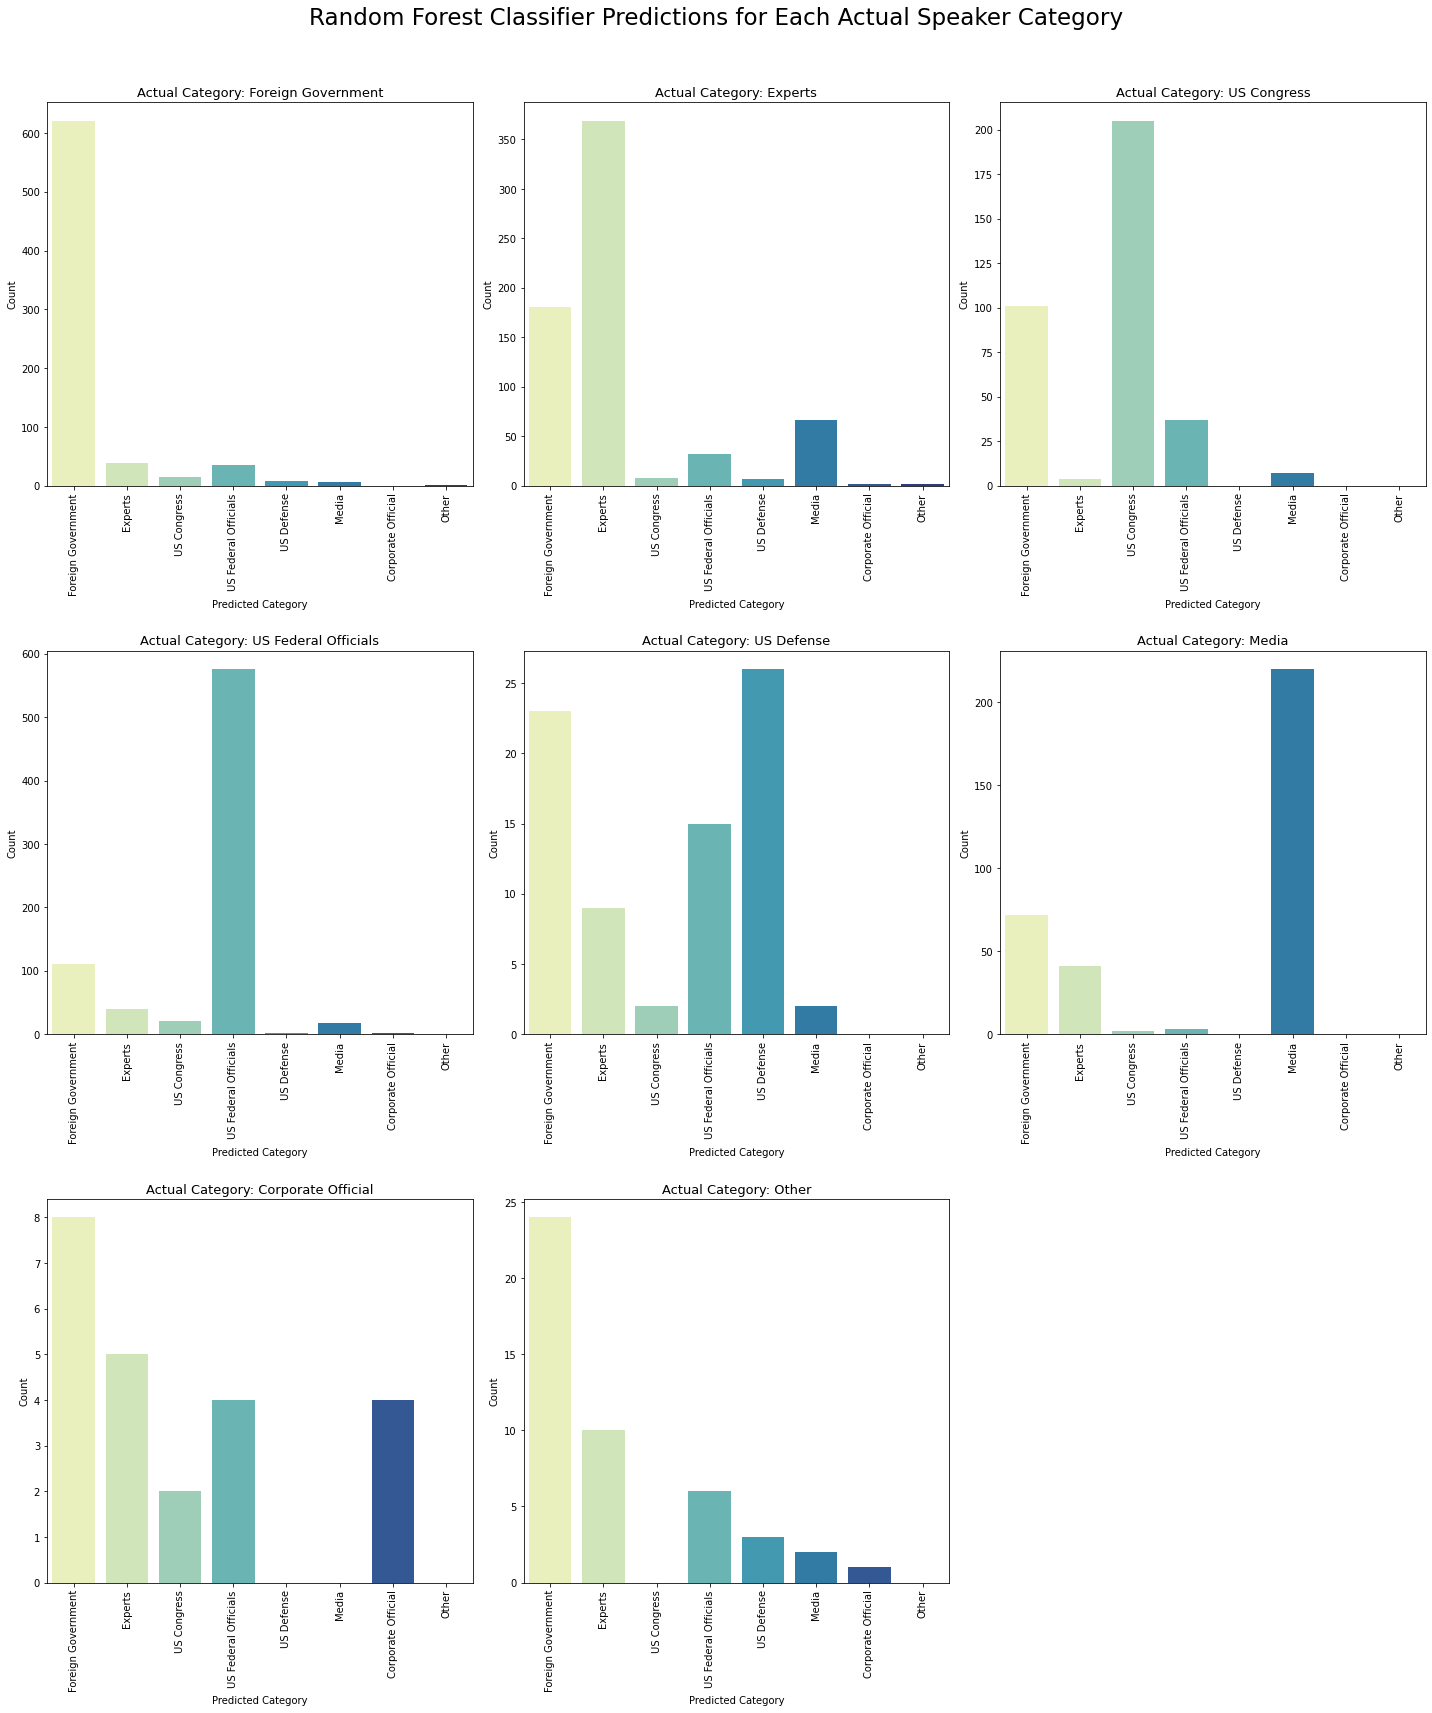

In [134]:
# plotting the results of the code above: a complete error analysis of where the model predicts
# correctly and incorrectly
fig = plt.figure(figsize=(20,25))
fig.suptitle("Random Forest Classifier Predictions for Each Actual Speaker Category",fontsize=23);
i = 0
for category in source_groups:
    code = 331 + i
    i += 1
    ax = fig.add_subplot(code)
    sns.barplot(x='index', y=category, data=count_df, palette="YlGnBu")
    plt.xlabel('');
    ax.set_title("\nActual Category: " + category,fontsize=13);
    ax.set_ylabel("Count");
    ax.set_xlabel("Predicted Category");
    ax.set_xticklabels(ordering.keys(),rotation=90);
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

# Brainstorming Classification Improvements

Want: a way to see specific prediction-reality mismatches and the context strings associated with them so we can see what exactly is going wrong with classifications

In [139]:
# creating a even smaller subsample of the quote data to perform error analysis on
sample_sample_qte_data = sample_qte_data.sample(n=1000)

In [141]:
# creating a column of random forest predictions for this subsample df
sample_sample_qte_data["forest_pred"] = forest_classify(sample_sample_qte_data["speaker_context"])

In [140]:
# helper function that pulls up a dataframe of times when the model made a particular prediction-reality mismatch.
# this allows us to look at the context string and see what improvements we can make from there.
def error_analysis_where(actual, predicted, df):
  return df[(df["speaker_group"]==actual) & (df["forest_pred"]==predicted)][["Article ID","cleaned_name","speaker_group","forest_pred","speaker_context"]]

In [143]:
# test of the error analysis function: find instances where the model predicted
# foreign govnernment when it should have predicted experts.
# Let's look at the context strings in each of these mismatches to see why
error_analysis_where(actual="Experts",predicted="Foreign Government",df=sample_sample_qte_data).head()

,Article ID,cleaned_name,speaker_group,forest_pred,speaker_context
9009,5188928,Annika Thunborg,Experts,[Foreign Government],"late stage,"" ctbto spokeswoman"
125614,3941946,Jung H. Pak (Brookings),Experts,[Foreign Government],# NO CONTEXT FOUND #
163861,5199481,Herman Nackaerts,Experts,[Foreign Government],announcement from mission leader
9285,5191002,Hamid Reza Taraghi,Experts,[Foreign Government],"for us,"" said hamidreza"
51768,5193707,Michelle Cann,Experts,[Foreign Government],michelle


# Feature Evaluation

Want: to see how much a difference each feature makes on the classifier's final decision, particularly the random forest since it has the highest accuracy on average.

In [150]:
# handling for special indicator
if 'foreign_title_tag' not in indicator_patterns:
  indicator_patterns.append('foreign_title_tag')

Text(0.5, 0, 'Mean decrease in impurity')

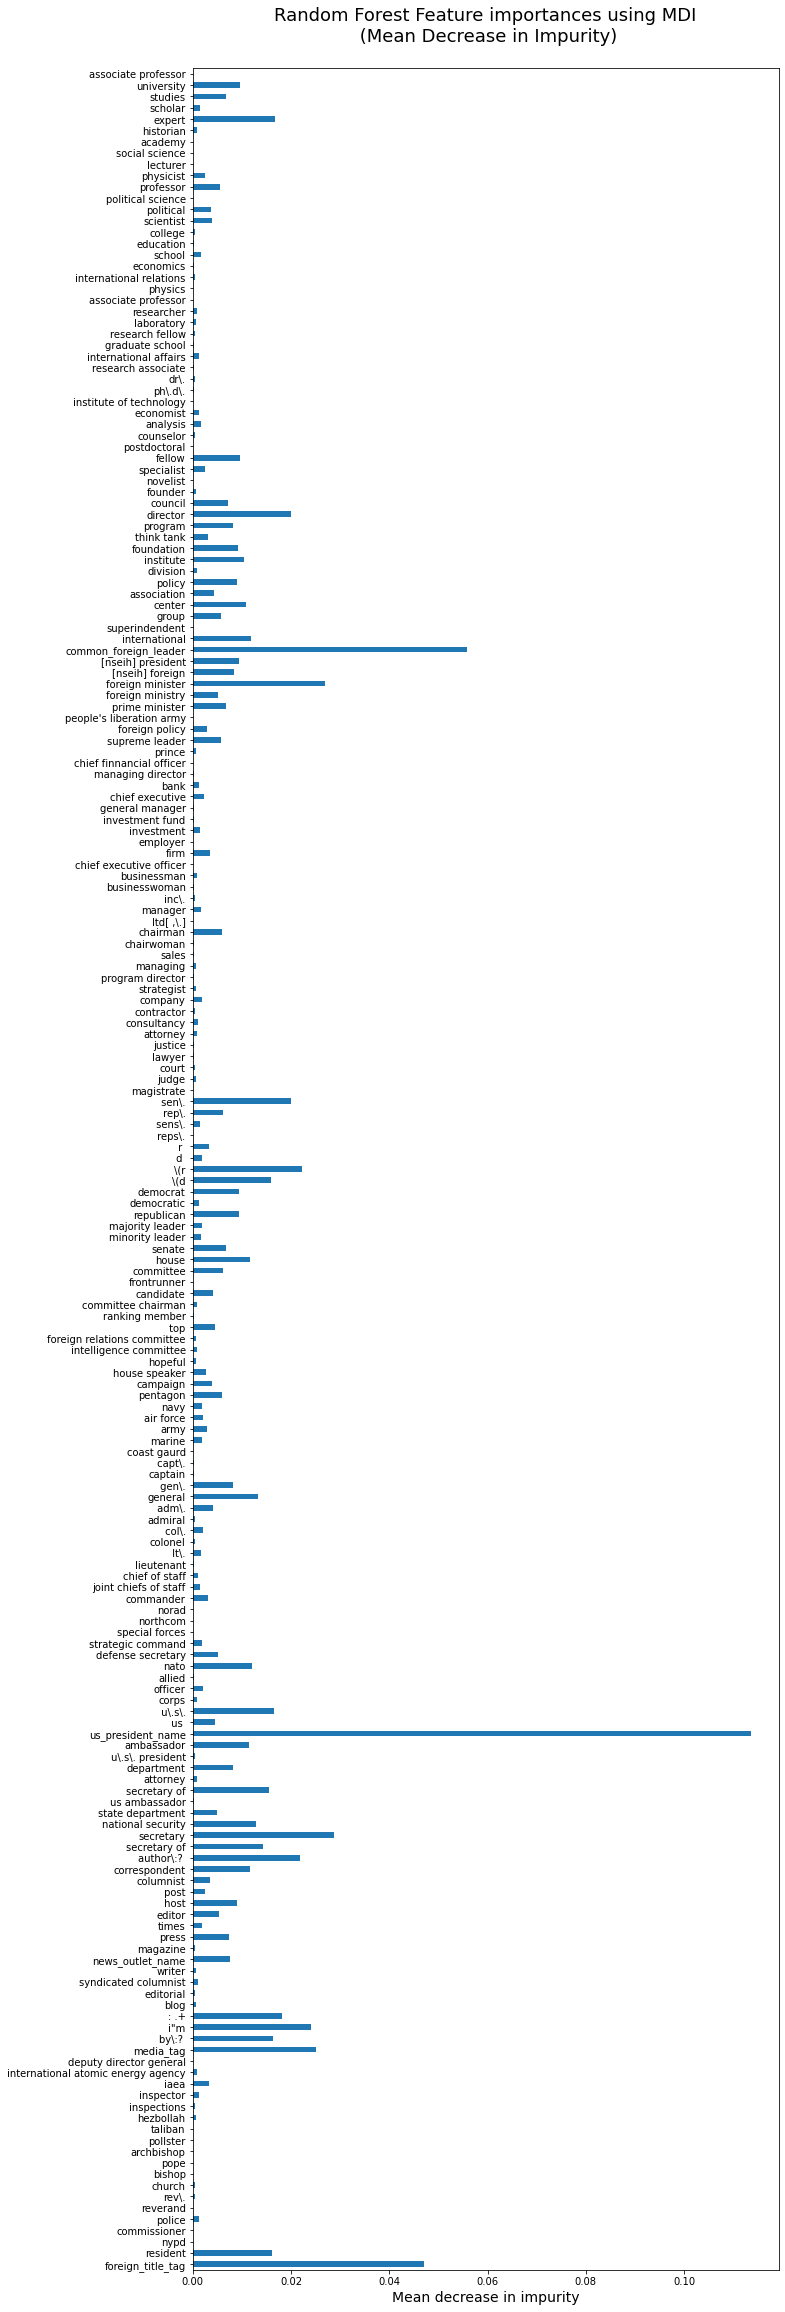

In [148]:
# get feature importances from the randforest classifier
importances = randforest_clf.feature_importances_
std = np.std([randforest_clf.feature_importances_ for tree in randforest_clf.estimators_], axis=0)

# modify the index to make sense
temp = indicator_patterns.copy()
idx = temp.index("biden|trump|obama|bush|clinton|reagan")
temp[idx] = "us_president_name"
idx = temp.index("putin|kim jong un|netanyahu|ayatollah|moon jae in")
temp[idx] = "common_foreign_leader"
idx = temp.index("msnbc|cnn|fox")
temp[idx] = "news_outlet_name"

# plot the result as a horizontal barplot
forest_importances = pd.Series(importances,index=temp)
forest_importances = forest_importances.iloc[::-1]
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 40.5)
forest_importances.plot.barh(yerr=std,ax=ax)
ax.set_title("Random Forest Feature importances using MDI\n (Mean Decrease in Impurity)\n",fontsize=18)
ax.set_xlabel("Mean decrease in impurity",fontsize=14)